# Gillespie's Stochastic Simulation Algorithm

L'algoritmo di simulazione di Gillespie ci serve per la simulazione di modelli chimici / biologici di equazioni stocastiche.
Basa il suo funzionamento sullo svolgimento di un numero importante di simulazioni da cui poi trarre output di rilevanza statistica.

## Algoritmo
L'algoritmo vero e proprio si esprime con:
$$
p(\tau,j|x,t) = a_j (\bold x)\exp(-\tau\sum_j a_j(\bold x))
$$
dove i termini $a$ sono le __propensities__ e $\bold x$ è il vettore di stato.

Per generare $\tau$ usiamo due numeri pseudo-randomici $r_1$ e $r_2$:
$$
\tau = \frac{1}{\sum_j a_j(\bold x)}\ln\left(\frac{1}{r_1}\right)
$$

mentre $j$ è il più piccolo intero che soddisfa la relazione:
$$
\sum_{k=1}^j a_k(\bold x) \geq r_2 \sum_j a_j(\bold x)
$$

## Implementazione
Importiamo le librerie che ci saranno necessarie per la simulazione.

In [9]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Implementiamo una classe modello che rappresenta effettivamente il modello da simulare.

In [10]:
class Model:
	def __init__(self, species=[], state=[], parameters=[], reactants_stoic=[], products_stoic=[]):
		""" 
			Initialization of the object with the information about the model. 
		"""
		self._species = species
		self._state = np.array(state)
		self._parameters = parameters
		self._reactants_stoic = np.array(reactants_stoic)
		self._products_stoic = np.array(products_stoic)
		self._propensities = np.zeros(len(self._parameters))
		self._time = 0

	def _get_h(self, index):
		""" 
			Calculate the combinations of reactants. 
		"""
		vector = self._reactants_stoic[index]
		if sum(vector)==0: return 1 # all zeros
		elif sum(vector)==1: # just one reactant
			return self._state[np.where(vector==1)][0]
		
		# Covering the general case
		else:
			# Case 1
			if sum(vector) == 2 and list(vector).count(1) == 2:
				return np.prod(np.array([self._state[i] for i in np.where(vector == 1)]))
			
			# Case 2
			if sum(vector)==2 and 2 in vector:
				return self._state[np.where(vector == 1)] * (self._state[np.where(vector == 1)]-1)/2
			# Case 3
			if sum(vector)==3 and list(vector).count(1) == 3:
				return np.prod(np.array([self._state[i] for i in np.where(vector == 1)]))

			# Case 4
			if sum(vector)==3 and 1 in vector and 2 in vector:
				return self._state[np.where(vector == 1)] * self._state[np.where(vector == 2)] * (self._state[np.where(vector == 2)]-1)/2
			
			# Case 5
			if sum(vector)==3 and 3 in vector:
				return self._state[np.where(vector == 3)] * (self._state[np.where(vector == 3)]-1) * (self._state[np.where(vector == 3)]-2)/6
				
		# to be continued..!
			
	def _update_propensities(self):
		""" 
			Update the propensities and a0 according to the current state.
		"""
		for m in range(len(self._parameters)):
			a = self._get_h(m) * self._parameters[m]
			self._propensities[m] = a
		self._a0 = sum(self._propensities)

	def SSA_step(self, tmax):
		""" 
			Performs a SSA step. Tmax is necessary in case the reactants are over
			and we must skip to the end of the simulation.
		"""
		self._update_propensities()
		if self._a0==0.0: return tmax, self._state.copy()
		tau = self._calculate_tau()
		index = self._get_next_reaction()
		self._time += tau
		change_vector = self._products_stoic[index] - self._reactants_stoic[index]
		self._state += change_vector
		return self._time, self._state.copy()

	def _calculate_tau(self):
		""" 
			Calculate the waiting time before the next reaction.
		"""
		return (1/self._a0) * (np.log(1/np.random.uniform()))

	def _get_next_reaction(self):
		""" 
			Calculate the next reaction with a roulette wheel.
		"""
		position = 0
		selected = 0
		rnd2 = self._a0*np.random.uniform()
		while (position<rnd2):
			position+=self._propensities[selected]
			selected+=1
		return selected-1

	def simulate(self, tmax):
		""" 
			Perform a complete SSA simulation up to tmax. Returns the time-series.
		"""
		states = []
		times  = []

		counter: int = 0
		while self._time <= tmax:
			new_time, new_state = self.SSA_step(tmax)
			times.append(new_time)
			states.append(new_state)

			if counter % 1000 == 0 and False:
				self.output_state()

			if self._a0 == 0.0:
				break

		return np.array(times), np.array(states) 

	def output_state(self):
		""" 
			Print the current state of the simulation.
		"""
		print('Time: ', self._time)
		for i in range(len(self._species)):
			print(self._species[i], ': ', self._state[i], end=", ")
		print('')

Procediamo ora a creare degli stati effettivamente da simulare: istanze del modello che debbano funzionare (le simuliamo diverse volte per ottenere dati con rilevanza statistica).

100%|██████████| 50/50 [00:04<00:00, 12.34it/s]
/var/folders/zw/3pdxl4cx4nz50_gtnwskqhqw0000gn/T/ipykernel_8060/3215940928.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


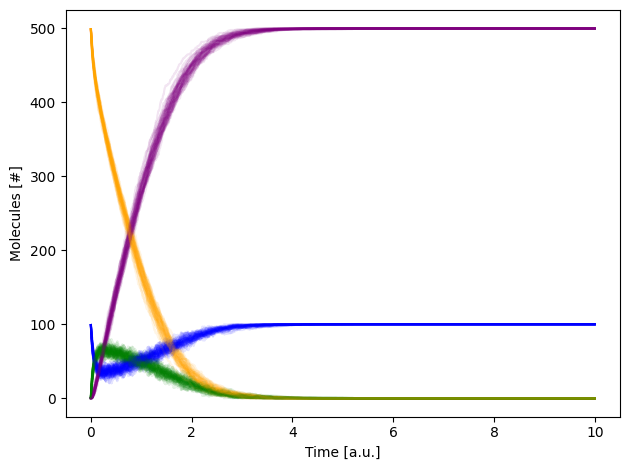

In [11]:
colors = ["orange", "blue", "green", "purple"]

fig, ax = plt.subplots(1,1)

for i in tqdm(range(50)):
	# Implementing the model:
	# A -> B
	# B -> A 
	base_model = Model(
		species=["S1", "S2"], 
		state = [100, 0],
		parameters = [0.5, 1e-2],
		reactants_stoic = [[1,0], [0,1]],  
		products_stoic = [[0,1], [1,0]]
	)

	michaelis_menten_model = Model(
		species=["S", "E", "ES", "P"],
		state = [500, 100, 0, 0],
		parameters = [0.025, 0.1, 5.0],
		reactants_stoic = [[1,1,0,0], [0,0,1,0], [0,0,1,0]],
		products_stoic = [[0,0,1,0], [1,1,0,0], [0,1,0,1]]
	)

	schlogl_model = Model(
		species=["A", "B", "X"],
		state = [1e5, 2e5, 250],
		parameters=[3e-7, 1e-4, 1e-3, 3.5],
		reactants_stoic=[[1, 0, 2], [0, 0, 3], [0, 1, 0], [0, 0, 1]],
		products_stoic=[[0, 0, 3], [1, 0, 2], [0, 0, 1], [0, 1, 0]]
	)

	M: Model = michaelis_menten_model
	
	times, states = M.simulate(tmax=10)
	for n, sp in enumerate(M._species):
		ax.plot(times, states.T[n], alpha=0.1, color=colors[n])
		
ax.set_xlabel("Time [a.u.]")
ax.set_ylabel("Molecules [#]")
fig.tight_layout()
fig.show()

Abbiamo simulato il nostro modello!